In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2222)

# Functions 

In [2]:
def plotLearnCurve(grid_summary, param):
    if len(param) == 1:
        fig, axes = plt.subplots(figsize=(8,6))
        x_val = grid_summary[param]
        max_score_idx = grid_summary.mean_validation_score.argmax()
        
        axes.plot(x_val, grid_summary['mean_validation_score'], 'C0', label='Mean AUC')
        
        lower = grid_summary['mean_validation_score'] - grid_summary['std_err']
        axes.plot(x_val, lower, 'C0', label='-1 Std.Err', linestyle='--')
        
        upper = grid_summary['mean_validation_score'] + grid_summary['std_err']
        axes.plot(x_val, upper, 'C0', label='+1 Std.Err', linestyle='--')
        
        best_lower = grid_summary.mean_validation_score.max() - grid_summary.std_err[max_score_idx]
        xmin = x_val.min()
        xmax = x_val.max()
        plt.hlines(xmin=xmin, xmax=xmax, y=best_lower, color='r')

        plt.legend()
        plt.tight_layout()
        plt.title("Learning Curve: " + str(param))
        
    else:
        fig, axes = plt.subplots(figsize=(8,6))
        plt_data = pd.pivot_table(grid_summary, index=param[0], columns=param[1])
        col_max = plt_data['mean_validation_score'].max().idxmax()
        row_max = plt_data['mean_validation_score'][col_max].idxmax()
        
        plt_data['mean_validation_score'].plot(ax=axes, figsize=(8,6))
        
        upper = (plt_data['mean_validation_score'] + plt_data['std_err'])
        upper.plot(ax=axes, figsize=(8,6),alpha=0.25,linestyle='--')
        
        lower = (plt_data['mean_validation_score'] - plt_data['std_err'])
        lower.plot(ax=axes, figsize=(8,6),alpha=0.25,linestyle='--')
        
        best_lower = plt_data['mean_validation_score'].loc[row_max, col_max] - \
                                plt_data['std_err'].loc[row_max, col_max]
        xmin = plt_data.index.values.min()
        xmax = plt_data.index.values.max()
        plt.hlines(xmin=xmin, xmax=xmax, y=best_lower, color='r')
        
        plt.title("Learning Curve: " + str(param))
        
        
def gridSearchSummary(grid_search):
    grid_summary = pd.DataFrame(grid_search.grid_scores_)
    
    params_summary = defaultdict(list)
    for row in grid_summary.parameters:
        for key, value in row.items():
            params_summary[key] += [value]
    params_summary_df = pd.DataFrame(params_summary)
    
    grid_summary.drop('parameters', 1, inplace=True)
    grid_summary = params_summary_df.join(grid_summary)
    std_err = grid_summary.cv_validation_scores.apply(lambda x: np.sqrt(np.var(x)/len(x)))
    grid_summary.insert(grid_summary.columns.get_loc("mean_validation_score")+1, 'std_err', std_err)
    
    return grid_summary

def tuningIteration(estimator, param_grid, X, Y):
    pipeline = Pipeline([('variance_thresh', VarianceThreshold()), ('estimator', estimator)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='roc_auc')
    grid_search.fit(X, Y)
    print("Best Score: {:0.6}\n".format(grid_search.best_score_))
    print("Best Params: ",grid_search.best_params_)
    grid_summary = gridSearchSummary(grid_search)
    plotLearnCurve(grid_summary, list(param_grid.keys()))

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

def loadSentimentData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, index_col=0)
    data.dropna(inplace=True)
    data.drop(['arousal_mv','valence_mv','label'], 1, inplace=True)
    data.index = data.index.astype('int64')
    
    return data

def loadUserData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, encoding="cp1252")
    data = data[['id','favourites_count','followers_count','friends_count','listed_count','statuses_count', 'label', 'default_profile', 'default_profile_image','verified']]
    data.set_index('id', inplace=True)
    
    return data

def loadTimingData(fileName):
    data = pd.read_csv(datadir + fileName, header=0)
    data.set_index('user_id', inplace=True)
    
    return data

def loadData(fileNames):
    sentiment = loadSentimentData(fileNames[0])
    account = loadUserData(fileNames[1])
    timing = loadTimingData(fileNames[2])
    data = account.join(sentiment, how='left')
    data = data.join(timing, how='left')
    
    mv_cols = (pd.isnull(data)).any()
    for each_col, each_bool in zip(mv_cols.index.values, mv_cols):
        data[each_col+'_mv'] = np.where(np.isnan(data[each_col]), 1, 0)
        col_mean = data[each_col].mean()
        data[each_col] = data[each_col].fillna(col_mean)
        
    return data
    
data = loadData(['sentiment_dist_varol_dump.csv','varol-2017-users.csv','timing.csv'])

NameError: name 'os' is not defined

# Feature Selection

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', 1), data.label, test_size=0.2, random_state=1001)

X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

not_scalable= ['default_profile', 'default_profile_image', 'verified']

scalable = X_train.columns.difference(not_scalable)
scaler = StandardScaler()
scaler.fit(X_train[scalable].copy())
X_train_scale[scalable] = scaler.transform(X_train_scale[scalable])
X_test_scale[scalable] = scaler.transform(X_test_scale[scalable])

In [5]:
# DecisionTree for MI scores
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

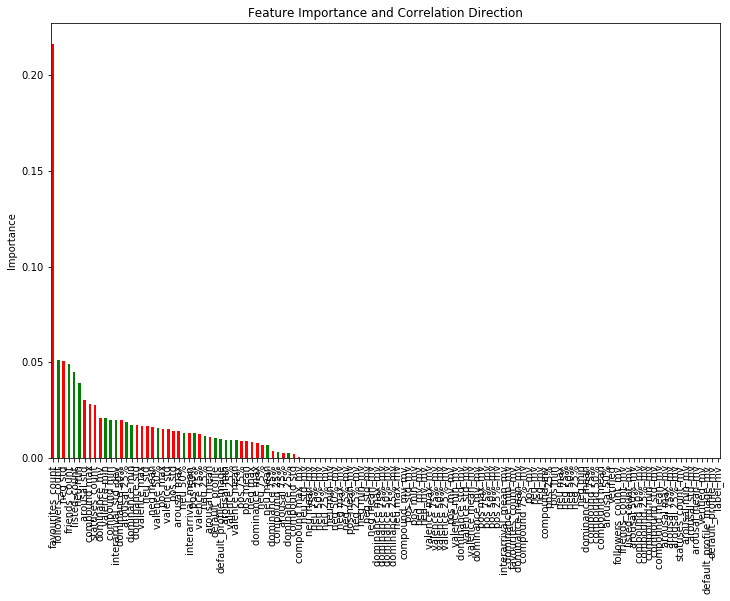

In [6]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [7]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

In [13]:
# Baseline Logistic Regression and SVM
lr = LogisticRegression(C=1e30)
svm = SVC(kernel="linear")
knn = KNeighborsClassifier(35)

svm_pipeline = Pipeline(steps = [('normalize', Normalizer()),
                                 ('estimator', svm)])

knn_pipeline = Pipeline(steps = [('normalize', Normalizer()),
                                 ('estimator', knn)])

kfold = KFold(10, True)
lr_cv = cross_val_score(lr, X_train, Y_train, cv = kfold, scoring="roc_auc")
svm_cv = cross_val_score(svm_pipeline, X_train, Y_train, cv = kfold, scoring="roc_auc")
knn_cv = cross_val_score(knn_pipeline, X_train, Y_train, cv = kfold, scoring="roc_auc")

In [14]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

print("\nSVM Mean CV AUC Score: {:0.3}".format(np.mean(svm_cv))+
      "\nSVM StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(svm_cv)/len(svm_cv))))

print("\nKNN Mean CV AUC Score: {:0.3}".format(np.mean(knn_cv))+
      "\nKNN StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(knn_cv)/len(knn_cv))))

LR Mean CV AUC Score: 0.74
LR StdErr CV AUC Score: 0.00931

SVM Mean CV AUC Score: 0.692
SVM StdErr CV AUC Score: 0.00972

KNN Mean CV AUC Score: 0.673
KNN StdErr CV AUC Score: 0.0107


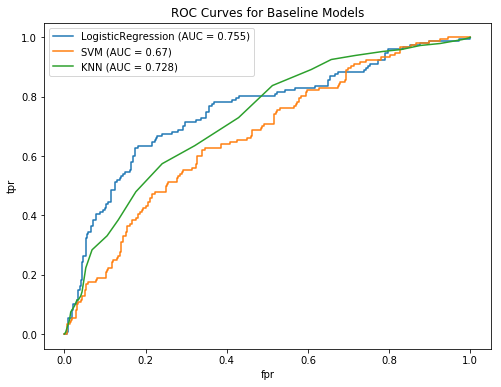

In [23]:
# ROC Curve for single test split baseline models
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_zip = zip([preds_lr, preds_svm, preds_knn], ["LogisticRegression", "SVM", "KNN"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for Baseline Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Pipelines

In [19]:
lr_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('estimator', LogisticRegression())])

svm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('normalize', Normalizer()),
                        ('estimator', SVC())])

gbm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('estimator', GradientBoostingClassifier())])

# GBM Tuning 

## Iteration 1

Best Score: 0.858473

Best Params:  {'estimator__n_estimators': 50}


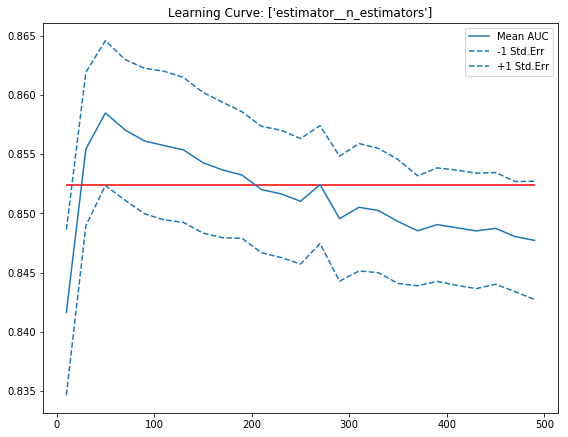

In [24]:
tuningIteration(GradientBoostingClassifier(),
                {'estimator__n_estimators': list(range(10,500,20))},
                X_train_filt, Y_train)

## Iteration 2 

Best Score: 0.858217

Best Params:  {'estimator__max_depth': 3}


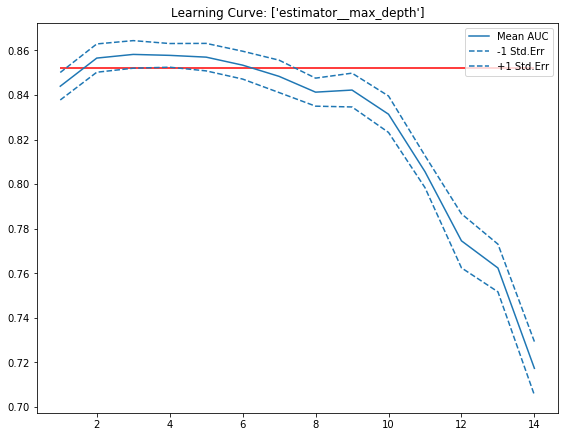

In [25]:
tuningIteration(GradientBoostingClassifier(n_estimators=50),
                {'estimator__max_depth': list(range(1,15))},
                X_train_filt, Y_train)

## Iteration 3

Best Score: 0.859076

Best Params:  {'estimator__min_samples_leaf': 225}


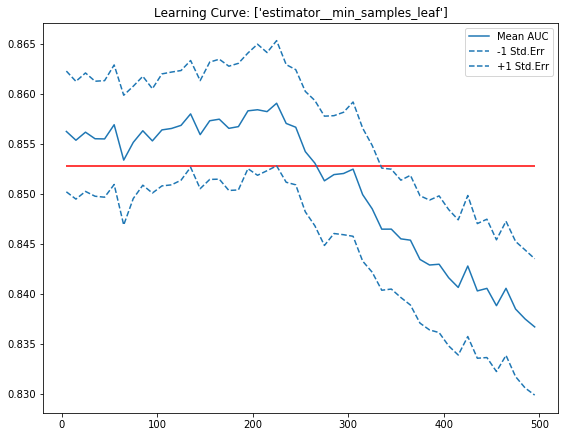

In [26]:
tuningIteration(GradientBoostingClassifier(n_estimators=50, max_depth=2),
                {'estimator__min_samples_leaf': list(range(5,500,10))},
                X_train_filt, Y_train)

## Iteration 4

Best Score: 0.858864

Best Params:  {'estimator__max_features': 16}


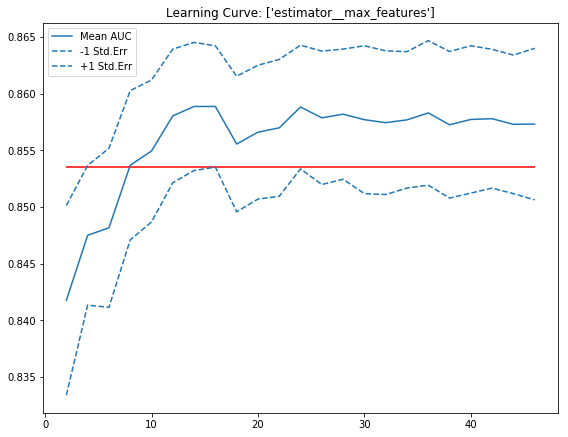

In [30]:
tuningIteration(GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215),
                {'estimator__max_features': list(range(2,X_train_filt.shape[1],2))},
                X_train_filt, Y_train)

## Iteration 5

Best Score: 0.857532

Best Params:  {'estimator__subsample': 1.0}


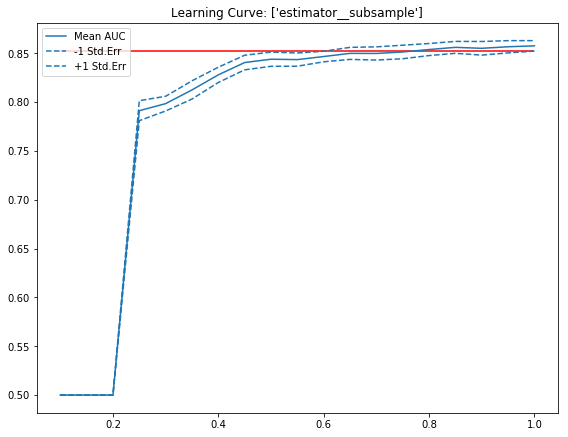

In [32]:
tuningIteration(GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100},
                X_train_filt, Y_train)

## Interation 6 

Best Score: 0.862277

Best Params:  {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 230}


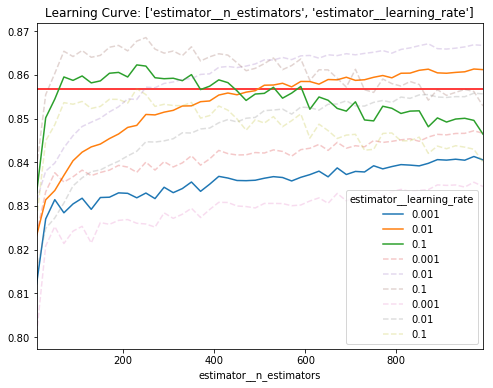

In [47]:
tuningIteration(GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85),
                {'estimator__n_estimators': list(range(10,1000,20)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]},
                X_train_filt, Y_train)

## Iteration 7 

Best Score: 0.862677

Best Params:  {'estimator__n_estimators': 1200}


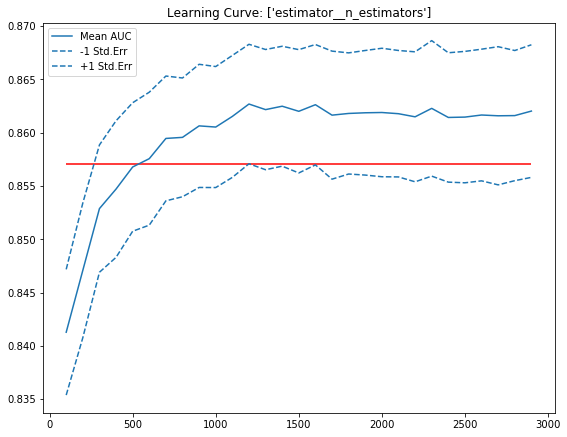

In [40]:
tuningIteration(GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=215, max_features=14,
                                           subsample=0.85, learning_rate=0.01),
                {'estimator__n_estimators': list(range(100,3000,100))},
                X_train_filt, Y_train)

## Compare Results

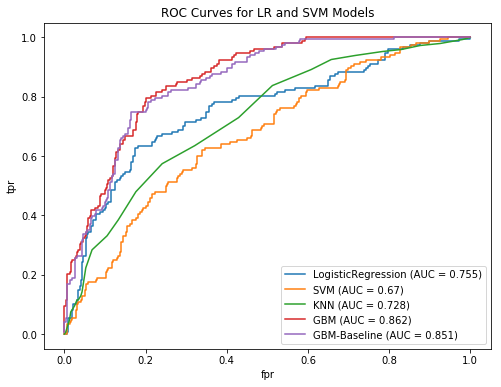

In [46]:
# ROC Curve for test split
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

gbm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', GradientBoostingClassifier(n_estimators=1200,max_depth=2,
                                                                        min_samples_leaf=215, max_features=14,
                                                                        subsample=0.85, learning_rate=0.01))])

gbm_pipeline_baseline = Pipeline([('variance_thresh', VarianceThreshold()),
                                  ('estimator', GradientBoostingClassifier())])


gbm_pipeline_final.fit(X_train_filt, Y_train)
gbm_pipeline_baseline.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_gbm = gbm_pipeline_final.decision_function(X_test_filt)
preds_gbm2 = gbm_pipeline_baseline.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm, preds_knn, preds_gbm, preds_gbm2],
                ["LogisticRegression", "SVM", "KNN", "GBM", "GBM-Baseline"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Brute Force Grid Search 

In [ ]:
lr_param_grid = {'estimator__C': [10**x for x in range(-8,3)]}

svm_param_grid = {'estimator__C': [10**x for x in range(-8,3)],
                  'estimator__kernel': ['linear','poly','rbf','sigmoid'],
                  'estimator__degree': [2,3,4]}

gbm_param_grid = {'estimator__learning_rate': [10**x for x in range(-8,0)],
                  'estimator__max_depth': list(range(2,16)),
                  'estimator__min_samples_leaf': [5,25,50,100,250,500],
                  'estimator__subsample': [0.25,0.5,0.75,1],
                  'estimator__n_estimators': list(range(50,500,20)),
                  'estimator__max_features': list(range(1,30,5))}

In [ ]:
lr_grid_search = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, cv=10, scoring='roc_auc')
lr_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(lr_grid_search.best_score_))
print("Best Params: ",lr_grid_search.best_params_)

In [ ]:
svm_grid_search = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=10, scoring='roc_auc')
svm_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(svm_grid_search.best_score_))
print("Best Params: ",svm_grid_search.best_params_)

In [ ]:
gbm_grid_search = GridSearchCV(gbm_pipeline, param_grid=gbm_param_grid, cv=10, scoring='roc_auc')
gbm_grid_search.fit(X_train, Y_train)
print("Best Score: {:0.6}\n".format(gbm_grid_search.best_score_))
print("Best Params: ",gbm_grid_search.best_params_)

In [ ]:
# ROC Curve for single test split
lr.fit(X_train_filt, Y_train)
svm_pipeline.fit(X_train_filt, Y_train)
gmm_pipeline.fit(X_train_filt, Y_train)
knn_pipeline.fit(X_train_filt, Y_train)

gbm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', GradientBoostingClassifier(learning_rate=0.1, max_depth = 20,
                                                                        min_samples_leaf=5, subsample=0.27))])

gbm_pipeline_final.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm_pipeline.decision_function(X_test_filt)
preds_knn = knn_pipeline.predict_proba(X_test_filt)[:,lr_pos_class]
preds_gbm = gbm_pipeline_final.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm, preds_knn, preds_gbm], ["LogisticRegression", "SVM", "KNN", "GBM"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()